In [1]:
# Prepare environment to import files
import prepare_notebook 

Dodano do ścieżki: /home/edwinh/drone-swarm-simulation


In [2]:
# World generation imports
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import NamedTuple, Literal, Callable, Optional, Protocol, Dict, Any, List
from numpy.typing import NDArray
from src.environments.abstraction.generate_obstacles import generate_obstacles, ObstaclesData, strategy_random_uniform, strategy_grid_jitter
from src.environments.abstraction.generate_world_boundaries import generate_world_boundaries, WorldData

# Trajectory counting imports
from src.algorithms.abstraction.count_trajectories import count_trajectories
from src.algorithms.abstraction.trajectory.strategies.linear_trajectory import linear_trajectory
from src.algorithms.abstraction.trajectory.strategies.nsga3_swarm_strategy import nsga3_swarm_strategy

# Ustawienie ziarna losowości dla powtarzalności wyników
np.random.seed(40)

print("Biblioteki załadowane.")

pybullet build time: Jan 29 2025 23:16:28
/home/edwinh/miniconda3/envs/drone-swarm-env/lib/python3.10/site-packages/gym_pybullet_drones/control/BaseControl.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Biblioteki załadowane.


In [3]:
# utils for drawing things
def plot_world_scenario(world: WorldData, obstacles_list: list[ObstaclesData], title="World Scenario"):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Rysowanie granic świata (Wireframe Box)
    mx, my, mz = world.max_bounds
    # ... (kod rysowania pudełka świata - uprośćmy do osi)
    
    colors = {'CYLINDER': 'red', 'BOX': 'blue'}
    
    print(f"Rysowanie świata: {mx}x{my}x{mz}m")
    
    for obs_batch in obstacles_list:
        data = obs_batch.data
        shape = obs_batch.shape_type
        print(f" -> Batch: {shape}, Count: {obs_batch.count}")
        
        for i in range(obs_batch.count):
            x, y, z, d1, d2, d3 = data[i]
            
            if shape == 'CYLINDER':
                # d1=radius, d2=height
                draw_cylinder(ax, x, y, d1, d2, color=colors[shape])
            elif shape == 'BOX':
                # d1=len, d2=wid, d3=height
                draw_box(ax, x, y, d1, d2, d3, color=colors[shape])

    # Ustawienia osi
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(title)
    ax.set_xlim(0, mx)
    ax.set_ylim(0, my)
    ax.set_zlim(0, mz)
    ax.set_box_aspect([mx, my, mz]) 
    plt.show()

# --- Pomocnicze funkcje rysujące (znane z wcześniejszych kroków) ---
def draw_cylinder(ax, x, y, r, h, color='red'):
    z = np.linspace(0, h, 10)
    theta = np.linspace(0, 2*np.pi, 15)
    theta_grid, z_grid = np.meshgrid(theta, z)
    x_grid = x + r * np.cos(theta_grid)
    y_grid = y + r * np.sin(theta_grid)
    ax.plot_surface(x_grid, y_grid, z_grid, color=color, alpha=0.3)

def draw_box(ax, x, y, l, w, h, color='blue'):
    # Proste rysowanie pudełka jako wireframe lub punktów (dla szybkości w matplotlib)
    # Rysujemy środek podstawy + wysokość
    ax.bar3d(x - l/2, y - w/2, 0, l, w, h, color=color, alpha=0.3, edgecolor='k')


Rysowanie świata: 300.0x1000.0x100.0m
 -> Batch: BOX, Count: 5


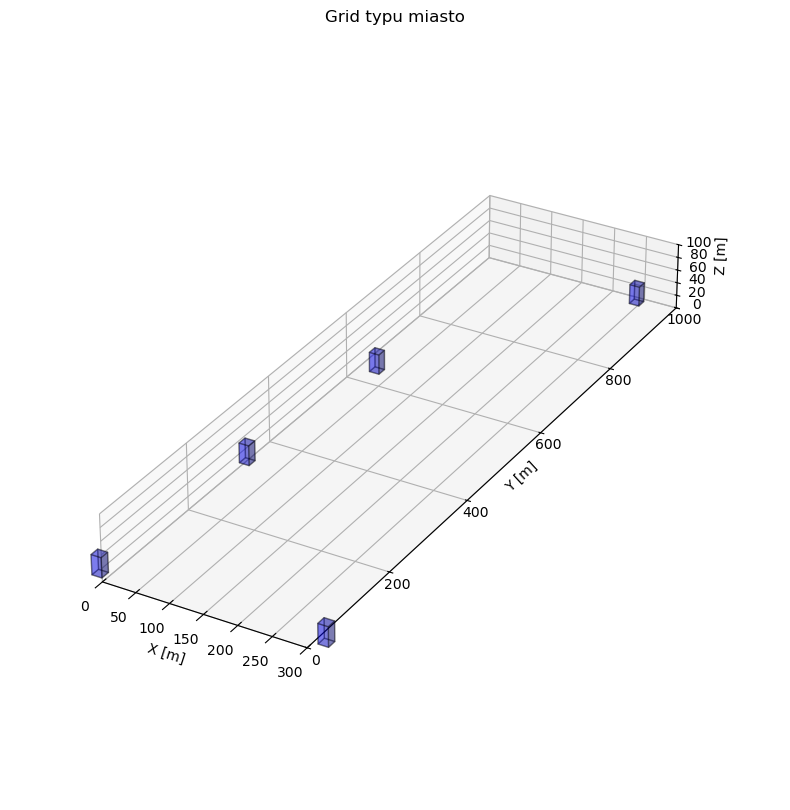

In [4]:
# world generation
#### 1. Definiujemy Świat
"""
  city_length: 1000.0
  city_width: 300.0
  block_size: 30.0
  street_width: 10.0
  min_height: 15.0
  max_height: 60.0
  skyscraper_prob: 0.15
"""
world_def = generate_world_boundaries(width=300.0, length=1000.0, height=100.0, ground_height=0.1)

# 2. Generujemy Miasto (Pudełka w siatce)
city_grid = generate_obstacles(
    world_def,
    n_obstacles=5,
    shape_type='BOX',
    placement_strategy=strategy_grid_jitter,
    size_params={'length': 15.0, 'width': 15.0, 'height': 30.0}
)

# 4. Wizualizacja obu zestawów naraz
plot_world_scenario(world_def, [city_grid], title="Grid typu miasto")


In [5]:
# algorithm parameters preparation
n_waypoints = 100       # Liczba punktów trasy
drone_swarm_size = 5    # Wielkość roju

# drones positions
center_x = world_def.center[0]
spacing_x = 5.0
start_xs = np.linspace(center_x - (spacing_x * (drone_swarm_size // 2)), 
                       center_x + (spacing_x * (drone_swarm_size // 2)), 
                       drone_swarm_size)

# sligthly minus to avoid obstacles in the start
start_y_value = 1.0
start_ys = np.full(drone_swarm_size, start_y_value)

# start from the ground
start_zs = np.full(drone_swarm_size, 0.5)

# Compounding to tensor (N, 3)
start_positions = np.column_stack((start_xs, start_ys, start_zs)).astype(np.float64)

# Target 
target_y_value = world_def.max_bounds[1] - 1  # Koniec mapy w Y
target_z_value = 10.0
target_xs = start_xs
target_ys = np.full(drone_swarm_size, target_y_value)
target_zs = np.full(drone_swarm_size, target_z_value)

target_positions = np.column_stack((target_xs, target_ys, target_zs)).astype(np.float64)
print("Przykładowe pozycje startowe (X, Y, Z):\n", start_positions)
print("Przykładowe pozycje celu (X, Y, Z): \n", target_positions)



Przykładowe pozycje startowe (X, Y, Z):
 [[140.    1.    0.5]
 [145.    1.    0.5]
 [150.    1.    0.5]
 [155.    1.    0.5]
 [160.    1.    0.5]]
Przykładowe pozycje celu (X, Y, Z): 
 [[140. 999.  10.]
 [145. 999.  10.]
 [150. 999.  10.]
 [155. 999.  10.]
 [160. 999.  10.]]


In [6]:
# counting trajectories with linear method

generated_trajectories = count_trajectories(
    world_data=world_def,
    obstacles_data=city_grid,
    counting_protocol=linear_trajectory,  # Przekazujemy funkcję strategii
    drone_swarm_size=drone_swarm_size,
    number_of_waypoints=n_waypoints,
    start_positions=start_positions,
    target_positions=target_positions,
    algorithm_params=None
)

In [7]:
# --- 3. Wizualizacja trajektorii 3D ---
def plot_world_scenario_with_trajectories(
    world: WorldData, 
    obstacles_list: List[ObstaclesData], 
    trajectories: Optional[NDArray[np.float64]] = None,
    start_positions: Optional[NDArray[np.float64]] = None,
    target_positions: Optional[NDArray[np.float64]] = None,
    title="Symulacja Roju Dronów"
):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # --- 1. Rysowanie granic świata ---
    mx, my, mz = world.max_bounds
    # Rysujemy proste krawędzie pudełka świata dla orientacji
    # (Uproszczona wizualizacja granic)
    ax.plot([0, mx, mx, 0, 0], [0, 0, my, my, 0], [0, 0, 0, 0, 0], 'k--', alpha=0.3) # Podłoga
    ax.plot([0, mx, mx, 0, 0], [0, 0, my, my, 0], [mz, mz, mz, mz, mz], 'k--', alpha=0.3) # Sufit
    
    # --- 2. Rysowanie przeszkód (Twoja logika) ---
    colors = {'CYLINDER': 'red', 'BOX': 'blue'}
    print(f"Rysowanie świata: {mx}x{my}x{mz}m")
    
    for obs_batch in obstacles_list:
        data = obs_batch.data
        shape = obs_batch.shape_type
        print(f" -> Batch: {shape}, Count: {obs_batch.count}")
        
        for i in range(obs_batch.count):
            # Zakładam strukturę danych [x, y, z, d1, d2, d3] zgodnie z Twoim kodem
            x, y, z, d1, d2, d3 = data[i]
            
            if shape == 'CYLINDER':
                # d1=radius, d2=height
                draw_cylinder(ax, x, y, d1, d2, color=colors.get(shape, 'red'))
            elif shape == 'BOX':
                # d1=len, d2=wid, d3=height
                draw_box(ax, x, y, d1, d2, d3, color=colors.get(shape, 'blue'))

    # --- 3. Rysowanie Trajektorii (Nowa warstwa) ---
    if trajectories is not None:
        num_drones = trajectories.shape[0]
        # Paleta kolorów, aby odróżnić drony
        colors_traj = plt.cm.jet(np.linspace(0, 1, num_drones))
        
        for i in range(num_drones):
            # Trajektoria: (W, 3)
            path = trajectories[i]
            xs, ys, zs = path[:, 0], path[:, 1], path[:, 2]
            
            # Linia ścieżki
            ax.plot(xs, ys, zs, color=colors_traj[i], linewidth=2, label=f'Dron {i+1}', alpha=0.8)
            
            # Punkt Startowy (jeśli podano)
            if start_positions is not None:
                sx, sy, sz = start_positions[i]
                ax.scatter(sx, sy, sz, color='green', marker='o', s=50, edgecolors='black', zorder=10)
            
            # Punkt Docelowy (jeśli podano)
            if target_positions is not None:
                tx, ty, tz = target_positions[i]
                ax.scatter(tx, ty, tz, color='red', marker='x', s=50, linewidth=2, zorder=10)

    # --- 4. Ustawienia widoku ---
    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_zlabel('Z [m]')
    ax.set_title(title)
    
    # Ustawienie limitów osi zgodnie z world_data
    ax.set_xlim(0, mx)
    ax.set_ylim(0, my) # Tu można dać start_y_value jeśli jest ujemne (np. -10, my)
    ax.set_zlim(0, mz)
    
    # Wymuszenie proporcji 1:1:1 (Ważne dla poprawnej oceny odległości w 3D)
    try:
        ax.set_box_aspect([mx, my, mz])
    except:
        # Fallback dla starszych wersji matplotlib
        pass

    # Legenda (tylko jeśli rysowaliśmy trajektorie)
    if trajectories is not None:
        ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        
    plt.show()

# Pamiętaj, aby mieć zdefiniowane funkcje pomocnicze draw_cylinder i draw_box w tym samym scope

Rysowanie świata: 300.0x1000.0x100.0m
 -> Batch: BOX, Count: 5


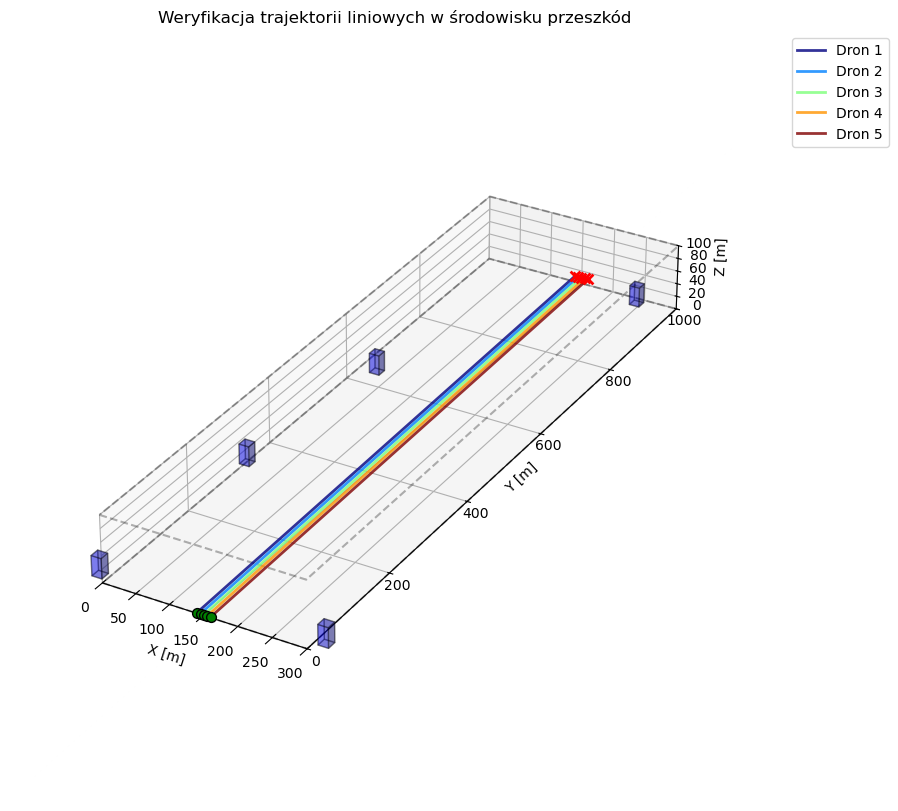

In [8]:
# Wyśweitelenie wykresu
plot_world_scenario_with_trajectories(
    world=world_def,
    obstacles_list=[city_grid],  # Przekazujemy jako listę, bo tak masz w pętli
    trajectories=generated_trajectories,
    start_positions=start_positions,
    target_positions=target_positions,
    title="Weryfikacja trajektorii liniowych w środowisku przeszkód"
)

In [9]:
# nsga3 test
# ==========================================
# CZĘŚĆ 2: TESTOWANIE STRATEGII NSGA-III (GPU/CPU)
# ==========================================

# 1. Import nowej strategii ewolucyjnej
# Upewnij się, że pliki stworzone w poprzednich krokach znajdują się w folderze src/strategies/nsga3_components/
try:
    from src.algorithms.abstraction.trajectory.strategies.nsga3_utils.swarm_evolution_strategy import nsga3_swarm_strategy
    print("✅ Pomyślnie zaimportowano moduł NSGA-III Swarm Strategy.")
except ImportError as e:
    print(f"❌ Błąd importu strategii NSGA-III: {e}")
    print("Upewnij się, że w folderze 'src/strategies/nsga3_components/' znajduje się pusty plik '__init__.py'")
    # Jeśli pracujesz w notebooku i właśnie dodałeś pliki, może być konieczny restart kernela.

#

✅ Pomyślnie zaimportowano moduł NSGA-III Swarm Strategy.



🚀 Uruchamianie symulacji NSGA-III...
   Parametry: {'pop_size': 406, 'n_gen': 400, 'n_control_points': 5, 'decision_mode': 'knee_point', 'min_dist': 0.001, 'ignore_ratio': 0.3}
   World data: WorldData(dimensions=array([ 300., 1000.,  100.]), min_bounds=array([0. , 0. , 0.1]), max_bounds=array([ 300., 1000.,  100.]), bounds=array([[0.e+00, 3.e+02],
       [0.e+00, 1.e+03],
       [1.e-01, 1.e+02]]), center=array([150.  , 500.  ,  50.05]))
   Obstacles data: ObstaclesData(data=array([[244.66796898, 985.98992728,   0.        ,  15.        ,
         15.        ,  30.        ],
       [314.66430163,  21.30800972,   0.        ,  15.        ,
         15.        ,  30.        ],
       [  1.62219301, 341.07193582,   0.        ,  15.        ,
         15.        ,  30.        ],
       [ 26.55732716, 636.15645594,   0.        ,  15.        ,
         15.        ,  30.        ],
       [-13.14556504,  14.80330483,   0.        ,  15.        ,
         15.        ,  30.        ]]), shape_type=

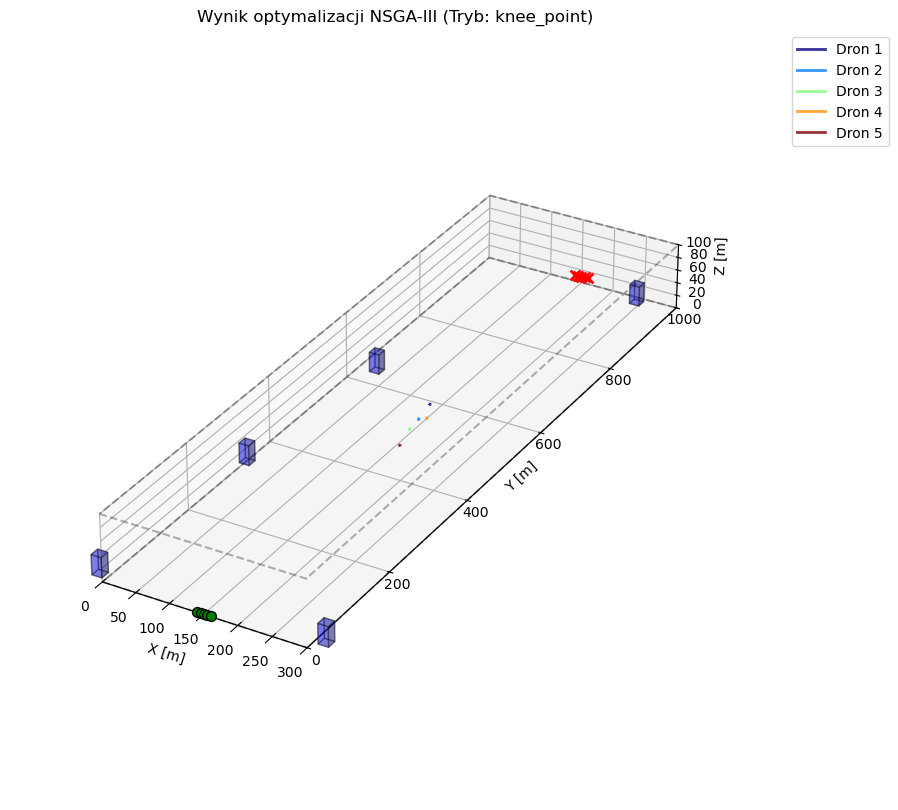

In [10]:
 #2. Konfiguracja parametrów algorytmu
# Tutaj definiujemy "charakter" naszego roju
evo_params = {
    "pop_size": 406,             # Wielkość populacji (na GPU można dać więcej, np. 500-1000)
    "n_gen": 400,                # Liczba generacji
    "n_control_points": 5,       # Liczba punktów kontrolnych B-Spline (4-6 jest optymalne dla miasta)
    "decision_mode": "knee_point",   # Tryb decydenta: 'knee_point', 'safety', 'equal'
    "min_dist": 0.001,             # Bezpieczny dystans między dronami [m]
    "ignore_ratio": 0.3          # Ignorowanie 10% trasy przy starcie/lądowniu dla kolizji roju
}

print(f"\n🚀 Uruchamianie symulacji NSGA-III...")
print(f"   Parametry: {evo_params}")
print(f"   World data: {world_def}")
print(f"   Obstacles data: {city_grid}")
print(f"   drone_swarm_size: {drone_swarm_size}")
print(f"   start_positions: {start_positions}")
print(f"   target_positions: {target_positions}")
print(f"   drone_swarm_size: {drone_swarm_size}")



# 3. Uruchomienie obliczeń
# Uwaga: Pierwsze uruchomienie może chwilę potrwać (kompilacja kerneli CUDA jeśli masz GPU)
nsga3_trajectories = count_trajectories(
    world_data=world_def,
    obstacles_data=[city_grid], # Przekazujemy listę batchy przeszkód
    counting_protocol=nsga3_swarm_strategy,
    drone_swarm_size=drone_swarm_size,
    number_of_waypoints=n_waypoints,
    start_positions=start_positions,
    target_positions=target_positions,
    algorithm_params=evo_params
)

# 4. Weryfikacja wyników
if np.all(nsga3_trajectories == 0):
    print("⚠️ OSTRZEŻENIE: Algorytm zwrócił same zera. Oznacza to brak znalezionych rozwiązań.")
else:
    print("✅ Obliczenia zakończone sukcesem.")
    
    # Obliczenie statystyk dla wybranej trasy (opcjonalne, dla Twojej informacji)
    # Możemy tu policzyć np. całkowitą długość
    diffs = np.diff(nsga3_trajectories, axis=1)
    dists = np.sqrt(np.sum(diffs**2, axis=-1))
    total_len = np.sum(dists)
    print(f"   Łączna długość tras roju: {total_len:.2f} m")

# 5. Wizualizacja Wyników
plot_world_scenario_with_trajectories(
    world=world_def,
    obstacles_list=[city_grid],
    trajectories=nsga3_trajectories,
    start_positions=start_positions,
    target_positions=target_positions,
    title=f"Wynik optymalizacji NSGA-III (Tryb: {evo_params['decision_mode']})"
)
